In [58]:
import os
import json
import time

import pandas as pd

#### Load

json, etc. https://www.realpythonproject.com/a-cheat-sheet-for-working-with-json-data-in-python/

In [53]:
# FIXING DUMB DUMP BUG
"""
DATA_DIR = os.path.join(os.getcwd(), 'data')
DATA_FILES = list(map(
                    lambda f: os.path.join(DATA_DIR, f), os.listdir(DATA_DIR)
                ))

for fp in DATA_FILES:
    filename = fp.split('/')[-1]
    NEW_DATA_PATH = os.path.join(os.getcwd(), 'data', f'fix__{filename}')
    with open(fp, 'r') as rf, open(NEW_DATA_PATH, 'w') as wf:
        tmp = rf.readlines()
        data = []
        
        wf.write('[')
        for line in tmp:
            if line[:2] == '}{':
                data.append('},{\n')
            else:
                data.append(line)

        wf.writelines(data)
        wf.write(']')
"""

In [ ]:
# Load one (sample)
DATA_PATH = os.path.join(os.getcwd(), 'data', 'fix__2020-04-20__0.json')

with open(DATA_PATH, 'r') as f:
    tmp = json.load(f)
    df = pd.DataFrame(tmp)

df.head()

In [3]:
# Load all
DATA_DIR = os.path.join(os.getcwd(), 'data')
DATA_FILES = list(map(
                    lambda f: os.path.join(DATA_DIR, f), os.listdir(DATA_DIR)
                ))

df = pd.DataFrame()

for fp in DATA_FILES:
    with open(fp, 'r') as f:
        tmp = json.load(f)
        tmp = pd.DataFrame(tmp)
    
    df = pd.concat([df, tmp])
    
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99975 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   author_id            99975 non-null  int64  
 1   id                   99975 non-null  int64  
 2   in_reply_to_user_id  29159 non-null  float64
 3   created_at           99975 non-null  object 
 4   lang                 99975 non-null  object 
 5   text                 99975 non-null  object 
 6   possibly_sensitive   99975 non-null  bool   
 7   source               99975 non-null  object 
dtypes: bool(1), float64(1), int64(2), object(4)
memory usage: 6.2+ MB


#### Exploration

In [4]:
df.head()

,author_id,id,in_reply_to_user_id,created_at,lang,text,possibly_sensitive,source
0,711679239,1516700055759118337,208429848.0,2022-04-20 08:47:26.000000,und,@Crypto_Niazi #FEG,False,Twitter for iPhone
1,1376829402122575872,1516700055759114244,241214642.0,2022-04-20 08:47:26.000000,en,@dexamol_ @NoCreative_eth @Paddy_Stash @HChipN...,False,Twitter Web App
2,1463462196499804162,1516700055641935873,NaN,2022-04-20 08:47:26.000000,en,"“When you have a dream, you’ve got to grab it ...",False,Twitter Web App
3,1500281789797236737,1516700055537094656,NaN,2022-04-20 08:47:26.000000,en,The rumours are not true. We will not be prici...,False,Twitter Web App
4,1187027027637014528,1516700055427854340,NaN,2022-04-20 08:47:26.000000,en,I just listed this bored ape NFT for 20 ETH in...,False,Twitter for Android


In [164]:
df.lang.unique()

array(['en'], dtype=object)

In [6]:
len(df.source.unique()), df.source.unique()[:10]

(778,
 array(['Twitter for iPhone', 'Twitter Web App', 'Twitter for Android',
        'TwitterTestingApp7', 'abnormal_crypto_app', 'TweetApp for iPhone',
        'IFTTT', 'TweetApp for Android', 'Tweep+', 'Twitter'], dtype=object))

In [7]:
# remove duplicate
df = df[~df.text.duplicated()]

In [8]:
df.created_at = pd.to_datetime(df.created_at)
df.created_at

0      2022-04-20 08:47:26
1      2022-04-20 08:47:26
2      2022-04-20 08:47:26
3      2022-04-20 08:47:26
4      2022-04-20 08:47:26
               ...        
9982   2022-04-20 07:07:53
9989   2022-04-20 07:07:53
9990   2022-04-20 07:07:53
9994   2022-04-20 07:07:53
9999   2022-04-20 07:07:53
Name: created_at, Length: 51569, dtype: datetime64[ns]

In [157]:
df.created_at.min()

Timestamp('2022-04-20 06:22:10')

#### Cleaning

In [83]:
sum(df.lang != 'en')

# skip translate; kelamaan.... (13k ~ 4 jam)

13536

In [89]:
df = df[df.lang == 'en']
df.shape

(38033, 9)

##### Emoji

In [42]:
import re
import string

from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from googletrans import Translator as GoogleTranslator

In [12]:
# From
# https://stackoverflow.com/a/58356570/8996974
def remove_emojis(data):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', data)

In [52]:
df.text.iloc[:5]

@Crypto_Niazi #FEG
@dexamol_ @NoCreative_eth @Paddy_Stash @HChipNFT @kukulabanze This is such a cool concept!
“When you have a dream, you’ve got to grab it and never let go.”
@sapeofficialeth is my dream what’s your’s 
https://t.co/e8pvUvkd3J
#bsape  #sape #safuape #crypto #eth #btc @sapeofficialeth https://t.co/IEc0awVfns https://t.co/vPoi5M4yUb
The rumours are not true. We will not be pricing @SmartPiggyNFT at 0.25 $ETH... if you guess our Mint Price you get a free NFT and $25 in ETH #HotMama 😱
.
.
.
#NFTCommunity #NFTsales #NFTgiveaway #NFTAlpha #NFTGiveaways #FreeNFT #FreeNFTs #fearthepiggy #smartpiggy #trending https://t.co/rCBPCtcooq
I just listed this bored ape NFT for 20 ETH in Opensea https://t.co/UQyWo73uI2


In [53]:
df.text = df.text.apply(remove_emojis)

In [54]:
df.text.iloc[:5]

@Crypto_Niazi #FEG
@dexamol_ @NoCreative_eth @Paddy_Stash @HChipNFT @kukulabanze This is such a cool concept!
“When you have a dream, you’ve got to grab it and never let go.”
@sapeofficialeth is my dream what’s your’s 
https://t.co/e8pvUvkd3J
#bsape  #sape #safuape #crypto #eth #btc @sapeofficialeth https://t.co/IEc0awVfns https://t.co/vPoi5M4yUb
The rumours are not true. We will not be pricing @SmartPiggyNFT at 0.25 $ETH... if you guess our Mint Price you get a free NFT and $25 in ETH #HotMama 
.
.
.
#NFTCommunity #NFTsales #NFTgiveaway #NFTAlpha #NFTGiveaways #FreeNFT #FreeNFTs #fearthepiggy #smartpiggy #trending https://t.co/rCBPCtcooq
I just listed this bored ape NFT for 20 ETH in Opensea https://t.co/UQyWo73uI2


##### Text

[Contekan](https://github.com/bayhaqy/analisa-sentimen)

In [69]:
# From
# https://github.com/ssut/py-googletrans/issues/301#issuecomment-888261389
from time import sleep
import backoff

class Translator:
    def __init__(self):
        self.client = GoogleTranslator()
        self.sleep_in_between_translations_seconds = 1
        self.source_language = "en"
        self.max_chunk_size = 4000

    def __createChunks(self, corpus):
        chunks = [corpus[i:i + self.max_chunk_size] for i in range(0, len(corpus), self.max_chunk_size)]
        return chunks

    def __sleepBetweenQuery(self):
        print('Sleeping for {}s after translation query..'.format(self.sleep_in_between_translations_seconds))
        sleep(self.sleep_in_between_translations_seconds)

    @backoff.on_exception(backoff.expo, Exception, max_tries=150)
    def Translate(self, content, dest_language_code):
        try:
            print('Attempting to translate to lang={}'.format(dest_language_code))
            if len(content) > self.max_chunk_size:
                print('Warning: Content is longer than allowed size of {}, breaking into chunks'.format(self.max_chunk_size))
                results_list = []
                concatenated_result = ""

                original_chunks = self.__createChunks(content)
                for i in original_chunks:
                    r = self.client.translate(i, dest=dest_language_code, src=self.source_language)
                    self.__sleepBetweenQuery()
                    results_list.append(r.text)

                for i in results_list:
                    concatenated_result += i

                return concatenated_result
            else:
                res = self.client.translate(content, dest=dest_language_code, src=self.source_language)
                self.__sleepBetweenQuery()
                return res.text
        except Exception as e:
            print(e)
            raise e

In [31]:
# Replace karakter berulang
def hapus_katadouble(tweet):
    pattern = re.compile(r"(.)\1{1,}", re.DOTALL)
    return pattern.sub(r"\1\1", tweet)

def clean_tweet(tweet):
    # Case folding
    tweet = tweet.lower()
  
    # Cleansing (Remove URL)
#     tweet = re.sub('http\S+|\S+co\S+', ' ', tweet)
    tweet = re.sub('http\S+|\S+co\S+', '', tweet)
    
    # Cleansing (Remove Mention)
    tweet = re.sub("@[A-Za-z0-9\S]+", "", tweet)
  
    # Cleansing (Remove Hastag)
#     tweet = re.sub(r'#([^\s]+)', r'\1', tweet)
    tweet = re.sub(r'#([^\s]+)', r'', tweet)
    
    # Cleansing (Remove Number and Punctuation)
    wrem_list = ('rt',)
    exclude = set (string.punctuation)
    rem_list = []
    token = tweet.split()
    for w in token:
        if w not in wrem_list:
            for x in w:
                if x in exclude or x.isdigit():
                    rem_list.append("")
                else:
                    rem_list.append(x)
            rem_list.append(" ")
    tweet = "".join(rem_list)
  
    tweet = hapus_katadouble(tweet)
  
    # hapus extra space dalam kalimat
    return " ".join(tweet.split())


# masukkan stopord tambahan
STOP_TAMBAH = None
extra_stopwords = os.path.join(os.getcwd(), 'extras', 'stop_tambah.txt')
with open(extra_stopwords) as f:
    tmp = f.readlines()
    STOP_TAMBAH = set(map(lambda x: x.rstrip('\n'), tmp))

# Preprocessing english
def preprocessing_en(tweet):

    # PorterStemmer English dari library NLTK
    stemmer = PorterStemmer()
    #stemmer = WordNetLemmatizer()

    token_words = word_tokenize(tweet)
    sentence = []
    for word in token_words:
        if word not in STOP_TAMBAH and len(word) > 1 and len(word) < 25:   
            sentence.append(stemmer.stem(word))
            #sentence.append(stemmer.lemmatize(word,pos='v'))
    return sentence
  

# Translate ke English menggunakan Google Translate
def gtrans_tweet_en(tweet, lang):
    if not tweet:
        return None
    
    if lang == "en":
        return tweet
    """
    try:
        lang = GoogleTranslator().detect(tweet).lang
    except:
        return None
    """
    
    translator = Translator()
    text = translator.Translate(tweet, dest='en').text
    
    return text


# Klasifikasi Polaritas Tweet menggunakan Vader
def sentiment_Vader(tweet):
    analysis = SentimentIntensityAnalyzer()
    analysis = analysis.polarity_scores(tweet)
    comm = analysis['compound']
    if (comm >= 0.05):
        return "Positive"
    elif ((comm > -0.05) and (comm < 0.05)):
        return "Neutral"
    else:
        return "Negative"

# Cek analisis sentimen dari English tweet menggunakan VADER
def sentiment_analysis_en(tweet):
    tweet = clean_tweet(tweet)
    
    # NO PREPROCESSING HAPPENS HERE
    
    tweet = gtrans_tweet_en(tweet)
    sentiment = sentiment_Vader(tweet)
    return sentiment

In [59]:
# sample
clean_tweet(df.text.iloc[3])

'the rumours are not true we will not be pricing at eth if you guess our mint price you get a free nft and in eth'

In [ ]:
# all in one, not preprocessed
# df['sentiment'] = df.text.apply(sentiment_analysis_en)

In [73]:
df['clean_tweet'] = df.text.apply(clean_tweet)

In [119]:
# discard empty string
df = df[df.clean_tweet != ""]

In [109]:
# SKIP TRANSLATE
# sample = df.iloc[0:10].copy()
# sample['clean_tweet_en'] = sample.apply(lambda x: gtrans_tweet_en(x['clean_tweet'], x['lang']), axis=1)
%timeit df['clean_tweet_en'] = df.apply(lambda x: gtrans_tweet_en(x['clean_tweet'], x['lang']), axis=1)

591 ms ± 105 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [130]:
sample = sample = df.iloc[0:10000].copy()

In [140]:
"""5 detik per 10k data"""
# %timeit df['preprocessed'] = df.clean_tweet_en.apply(preprocessing_en)
start = time.time()
sample['preprocessed'] = sample.clean_tweet_en.apply(preprocessing_en)
end = time.time()
print(end - start)

4.592994689941406


In [ ]:
# df['preprocessed'] = df.clean_tweet_en.apply(preprocessing_en)
# df['sentiment_clean_en'] = df.clean_tweet_en.apply(sentiment_Vader)

In [138]:
"""2 menit per 10k data"""
# %timeit df['sentiment_clean_en'] = df.clean_tweet_en.apply(sentiment_Vader)
start = time.time()
sample['sentiment_clean_en'] = sample.clean_tweet_en.apply(sentiment_Vader)
end = time.time()
print(end - start)

121.03955078125


In [143]:
sample.head()

,author_id,id,in_reply_to_user_id,created_at,lang,text,possibly_sensitive,source,clean_tweet,clean_tweet_en,preprocessed,sentiment_clean_en
1,1376829402122575872,1516700055759114244,241214642.0,2022-04-20 08:47:26,en,@dexamol_ @NoCreative_eth @Paddy_Stash @HChipN...,False,Twitter Web App,this is such a cool concept,this is such a cool concept,"[cool, concept]",Positive
2,1463462196499804162,1516700055641935873,NaN,2022-04-20 08:47:26,en,"“When you have a dream, you’ve got to grab it ...",False,Twitter Web App,“when you have a dream you’ve got to grab it a...,“when you have a dream you’ve got to grab it a...,"[dream, grab, never, dream]",Positive
3,1500281789797236737,1516700055537094656,NaN,2022-04-20 08:47:26,en,The rumours are not true. We will not be prici...,False,Twitter Web App,the rumours are not true we will not be pricin...,the rumours are not true we will not be pricin...,"[rumour, not, true, will, not, price, eth, if,...",Positive
4,1187027027637014528,1516700055427854340,NaN,2022-04-20 08:47:26,en,I just listed this bored ape NFT for 20 ETH in...,False,Twitter for Android,i just listed this bored ape nft for eth in op...,i just listed this bored ape nft for eth in op...,"[list, bore, ape, nft, eth, opensea]",Negative
5,1502908260659179521,1516700055423623172,NaN,2022-04-20 08:47:26,en,"Fuck it. Drop your $ETH wallets\n\nRT, Like\nF...",False,Twitter for Android,fuck it drop your eth wallets rt like follow me,fuck it drop your eth wallets rt like follow me,"[fuck, drop, eth, wallet, follow]",Negative


In [2]:
CHECKPOINT_PATH = os.path.join(os.getcwd(), 'extras', 'checkpoint.csv')

In [ ]:
sample.to_csv(CHECKPOINT_PATH, index=False)

#### Reload

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv(CHECKPOINT_PATH)
df.head()

,author_id,id,in_reply_to_user_id,created_at,lang,text,possibly_sensitive,source,clean_tweet,clean_tweet_en,preprocessed,sentiment_clean_en
0,1376829402122575872,1516700055759114244,241214642.0,2022-04-20 08:47:26,en,@dexamol_ @NoCreative_eth @Paddy_Stash @HChipN...,False,Twitter Web App,this is such a cool concept,this is such a cool concept,"['cool', 'concept']",Positive
1,1463462196499804162,1516700055641935873,NaN,2022-04-20 08:47:26,en,"“When you have a dream, you’ve got to grab it ...",False,Twitter Web App,“when you have a dream you’ve got to grab it a...,“when you have a dream you’ve got to grab it a...,"['dream', 'grab', 'never', 'dream']",Positive
2,1500281789797236737,1516700055537094656,NaN,2022-04-20 08:47:26,en,The rumours are not true. We will not be prici...,False,Twitter Web App,the rumours are not true we will not be pricin...,the rumours are not true we will not be pricin...,"['rumour', 'not', 'true', 'will', 'not', 'pric...",Positive
3,1187027027637014528,1516700055427854340,NaN,2022-04-20 08:47:26,en,I just listed this bored ape NFT for 20 ETH in...,False,Twitter for Android,i just listed this bored ape nft for eth in op...,i just listed this bored ape nft for eth in op...,"['list', 'bore', 'ape', 'nft', 'eth', 'opensea']",Negative
4,1502908260659179521,1516700055423623172,NaN,2022-04-20 08:47:26,en,"Fuck it. Drop your $ETH wallets\n\nRT, Like\nF...",False,Twitter for Android,fuck it drop your eth wallets rt like follow me,fuck it drop your eth wallets rt like follow me,"['fuck', 'drop', 'eth', 'wallet', 'follow']",Negative


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10002 entries, 0 to 10001
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   author_id            10002 non-null  object
 1   id                   10001 non-null  object
 2   in_reply_to_user_id  4046 non-null   object
 3   created_at           10001 non-null  object
 4   lang                 10001 non-null  object
 5   text                 10001 non-null  object
 6   possibly_sensitive   10000 non-null  object
 7   source               9999 non-null   object
 8   clean_tweet          9999 non-null   object
 9   clean_tweet_en       9999 non-null   object
 10  preprocessed         9999 non-null   object
 11  sentiment_clean_en   9999 non-null   object
dtypes: object(12)
memory usage: 937.8+ KB


In [10]:
df[df.sentiment_clean_en.isnull()]

,author_id,id,in_reply_to_user_id,created_at,lang,text,possibly_sensitive,source,clean_tweet,clean_tweet_en,preprocessed,sentiment_clean_en
1623,1214957598073589760,1516699613222387715,NaN,2022-04-20 08:45:41,en,$BAT seeing sustained chatter on 4chan over th...,NaN,NaN,NaN,NaN,NaN,NaN
1624,Via https://t.co/mgvOk9K8kd,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1625,#bat #4chan #blockchain https://t.co/AOZn5...,False,Twitter,bat seeing sustained chatter on chan over the ...,bat seeing sustained chatter on chan over the ...,"['bat', 'sustain', 'chatter', 'chan', 'day']",Neutral,NaN,NaN,NaN,NaN,NaN


In [14]:
df.dropna(subset=['sentiment_clean_en'], inplace=True)

In [15]:
df.created_at = pd.to_datetime(df.created_at)

In [16]:
positives = df[df['sentiment_clean_en'] == 'Positive'].copy()
negatives = df[df['sentiment_clean_en'] == 'Negative'].copy()

In [17]:
positives.shape, negatives.shape

((6214, 12), (940, 12))

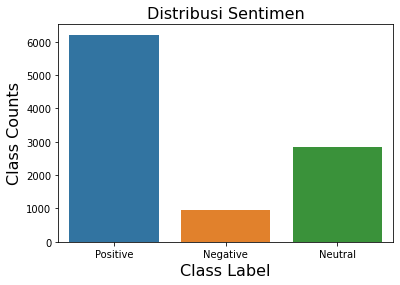

In [20]:
sns.countplot(x='sentiment_clean_en', data=df)
plt.title('Distribusi Sentimen', fontsize=16)
plt.ylabel('Class Counts', fontsize=16)
plt.xlabel('Class Label', fontsize=16)
plt.xticks(rotation='horizontal');

In [30]:
# negative examples
negatives.preprocessed

3        ['list', 'bore', 'ape', 'nft', 'eth', 'opensea']
4             ['fuck', 'drop', 'eth', 'wallet', 'follow']
6       ['partner', 'moonshot', 'garag', 'spot', 'lowe...
9       ['drop', 'eth', 'wallet', 'send', 'amp', 'foll...
47      ['tigray', 'peopl', 'face', 'repeat', 'faminei...
                              ...                        
9943    ['not', 'move', 'btcusdt', 'price', 'high', 'l...
9959    ['delay', 'will', 'delay', 'forev', 'eth', 'br...
9988                                           ['strang']
9993    ['doubt', 'can', 'buy', 'can', 'buy', 'correct...
9994    ['cri', 'harder', 'btch', 'nobodi', 'buy', 'st...
Name: preprocessed, Length: 940, dtype: object

#### Feature Engineering

In [49]:
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict, train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score,recall_score, precision_score, f1_score, \
                            roc_auc_score, confusion_matrix, roc_curve, auc, classification_report

In [35]:
df.columns

Index(['author_id', 'id', 'in_reply_to_user_id', 'created_at', 'lang', 'text',
       'possibly_sensitive', 'source', 'clean_tweet', 'clean_tweet_en',
       'preprocessed', 'sentiment_clean_en'],
      dtype='object')

In [40]:
posneg_df = df[df.sentiment_clean_en != 'Neutral']
X = posneg_df.loc[:, 'clean_tweet_en'].values

# Encode Data Label agar bisa diproses algoritma
le = LabelEncoder()
le.fit(["Positive", "Negative"])

print(list(le.classes_))
y = le.transform(posneg_df['sentiment_clean_en'])

# Mengecek contoh hasil column baru
#print(X.shape)
#print(y.shape)
print(X[10])
print(y[0])
print(X.dtype)
print(y.dtype)

['Negative', 'Positive']
metanova new btc reward token launching april nd on pancakeswap pinksale presale april th supply metanova telegram join private sale
1
object
int64


In [43]:
tfidfconverter = TfidfVectorizer(min_df=2,
                                 max_df=0.7,
                                 ngram_range=(1,3),
                                 stop_words = word_tokenize('english'),
                                 tokenizer=preprocessing_en)
X_vect = tfidfconverter.fit_transform(X).toarray()

#### Modeling

In [44]:
# Plot Confusion Matrix
def conf_matrix(cm):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
    classNames = ['Negative','Positive']
    plt.title('Confusion Matrix - Test Data Positive dan Negative')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames)
    s = [['TN','FP'], ['FN', 'TP']]
    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
    plt.show()

In [45]:
def roccurve(Y, y_pred):
    fpr, tpr, thresholds = roc_curve(Y, y_pred)
    roc_auc = auc(fpr,tpr)
    plt.plot(fpr, tpr, 'b',label='AUC = %0.3f'% roc_auc)
    plt.plot([0,1],[0,1],'k--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')

    # create the axis of thresholds (scores)
    ax2 = plt.gca().twinx()
    ax2.plot(fpr, thresholds, markeredgecolor='r',linestyle='dashed', color='r')
    ax2.set_ylabel('Threshold',color='r')
    ax2.set_ylim([thresholds[-1],thresholds[0]])
    ax2.set_xlim([fpr[0],fpr[-1]])
    plt.show()

In [46]:
def kfoldcv(classifier, X, Y, folds, print_all_scores=False, timed=True):
    # memulai timer
    mulai_time = time.time()

    # untuk mengecek feature matrix dan vector label  dengan format ndarray untuk mencegah masalah saat scalar indexing
    if type(X) is not np.ndarray:
        X = np.array(X)
    if type(Y) is not np.ndarray:
        Y = np.array(Y)

    # membuat dictionary untuk score
    scores=['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
    values = [np.array([]) for i in range(0, len(scores))]
    dict_score = OrderedDict(zip(scores, values))

    # menghitung score
    dict_score['accuracy'] = np.append(dict_score['accuracy'],cross_val_score(classifier, X, Y, scoring='accuracy', cv=folds))
    dict_score['precision']  = np.append(dict_score['precision'],cross_val_score(classifier, X, Y, scoring='precision', cv=folds))
    dict_score['recall'] = np.append(dict_score['recall'],cross_val_score(classifier, X, Y, scoring='recall', cv=folds))
    dict_score['f1'] = np.append(dict_score['f1'],cross_val_score(classifier, X, Y, scoring='f1', cv=folds))
    dict_score['roc_auc'] = np.append(dict_score['roc_auc'],cross_val_score(classifier, X, Y, scoring='roc_auc', cv=folds))

    y_pred = cross_val_predict(classifier, X, Y, cv=folds)
    cm = confusion_matrix(Y, y_pred)

    # print semua hasil score cross validation
    if print_all_scores:
        for score_name, scores in dict_score.items():
            print ("%s: %s" % (score_name, scores))

    # print hasil rata-rata score cross validation
    for score_name, scores in dict_score.items():
        print ("%s: %0.3f (+/- %0.3f)" % (score_name, scores.mean(), 2*scores.std()))

    # print waktu yang dibutuhkan untuk komputasi
    if timed:
        print ("Waktu yang dibutuhkan: %0.2fmins." % ((time.time() - mulai_time)/60))
    
    TN = cm[0][0]
    FP = cm[0][1]
    FN = cm[1][0]
    TP = cm[1][1]
    Totaldata = TN+FP+FN+TP
    Accuracy = ((TP + TN) / (TP + TN + FN + FP))
    Precision = (TP / (TP + FP))
    Recall = (TP / (TP + FN))
    F1 = (2 * (Precision * Recall) / (Precision + Recall))
    
    TPRate = Recall
    TNRate = (TN / (TN + FP))
    AUC = ((Recall + TNRate)/2)
    
    print("Confusion Matrix - Hitung Manual")
    print("TN %s FP %s" % (TN,FP))
    print("FN %s TP %s" % (FN,TP))
    print("Total data: %s" % (Totaldata))
    print("Accuracy  : %0.3f %%" % (Accuracy*100))
    print("Precision : %0.3f %%" % (Precision*100))
    print("Recall    : %0.3f %%" % (Recall*100))
    print("F1-Score  : %0.3f %%" % (F1*100))
    print("ROC-AUC   : %0.3f %%" % (AUC*100))
    conf_matrix(cm)
    print(classification_report(Y, y_pred))
    print("")
    print('Total Data Prediksi Negative ',sum(y_pred == 0))
    print('Total Data Prediksi Positive ',sum(y_pred == 1))
    print('Total Data Negative ',sum(Y == 0))
    print('Total Data Positive ',sum(Y == 1))
    print('Total Data ',len(Y))
    print("")    
    roccurve(Y,y_pred)
    
    #df_tfidf = pd.DataFrame(X,columns=tfidfconverter.get_feature_names())
    #df_tfidf['Sentiment'] = le.inverse_transform(Y)
    #df_tfidf['Sentiment_Pred'] = le.inverse_transform(y_pred)
        
    # export model
    #classifier.fit(X,Y)
    #pickle.dump(classifier, open('model1.pkl','wb'))
    # Copy ke Gdrive
    #!cp model1.pkl /content/gdrive/My\ Drive/'Colab Notebooks'/'Sentiment Analysis'/
    #!ls /content/gdrive/My\ Drive/'Colab Notebooks'/'Sentiment Analysis'/

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X_vect,
                                                    y,
                                                    test_size = 0.2,
                                                    stratify = y,
                                                    random_state = 42)

print(X_train.shape)
print(y_train.shape)

(5723, 14388)
(5723,)


In [51]:
classifier = LinearSVC(C=3.0)

#### Eval

In [59]:
import numpy as np
from collections import OrderedDict

In [52]:
y_pred = cross_val_predict(classifier, X_vect, y, cv=10)
cm = confusion_matrix(y, y_pred)
cm

array([[ 560,  380],
       [ 151, 6063]])

Algoritma Support Vector Machine
accuracy: 0.926 (+/- 0.016)
precision: 0.941 (+/- 0.014)
recall: 0.976 (+/- 0.012)
f1: 0.958 (+/- 0.009)
roc_auc: 0.934 (+/- 0.038)
Waktu yang dibutuhkan: 0.82mins.
Confusion Matrix - Hitung Manual
TN 560 FP 380
FN 151 TP 6063
Total data: 7154
Accuracy  : 92.578 %
Precision : 94.102 %
Recall    : 97.570 %
F1-Score  : 95.805 %
ROC-AUC   : 78.572 %


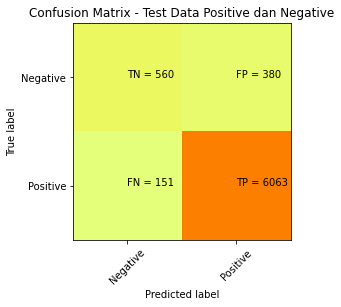

              precision    recall  f1-score   support

           0       0.79      0.60      0.68       940
           1       0.94      0.98      0.96      6214

    accuracy                           0.93      7154
   macro avg       0.86      0.79      0.82      7154
weighted avg       0.92      0.93      0.92      7154


Total Data Prediksi Negative  711
Total Data Prediksi Positive  6443
Total Data Negative  940
Total Data Positive  6214
Total Data  7154



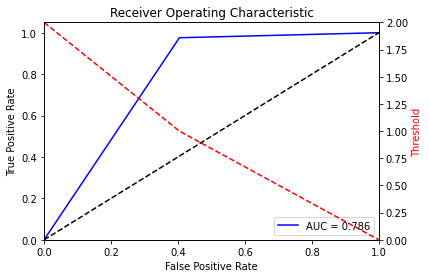

___________________________________________________________


In [60]:
print("Algoritma Support Vector Machine")
kfoldcv(classifier=LinearSVC(C=3.0), X=X_vect, Y=y, folds=10)
print('___________________________________________________________')

In [61]:
# Cek semua feature
print(tfidfconverter.get_feature_names())

# Melihat total feature dari yang terbesar
words = pd.DataFrame.from_dict(tfidfconverter.vocabulary_,orient='index',columns=['Count'])
words.sort_values('Count',ascending=False)[:5]

['aapl', 'aav', 'abil', 'abil convert', 'abil convert usdt', 'abil help', 'abil help peopl', 'abl', 'abl claim', 'abl claim reward', 'abl earn', 'abl earn financi', 'abl file', 'abl file crypto', 'abl pay', 'abl pay transact', 'abl track', 'abl track launch', 'abl work', 'abl work hope', 'absolut', 'abstract', 'abstract collect', 'abstract collect click', 'academi', 'academi cex', 'academi cex list', 'acceler', 'accept', 'accept crypto', 'accept crypto payment', 'accept cryptocurr', 'accept eth', 'accept offer', 'accept offer price', 'accept payment', 'accept payment lightn', 'accept payment shiba', 'accept shib', 'access', 'access dao', 'access dao bsape', 'access repli', 'access repli join', 'accident', 'accumul', 'accur', 'accur trade', 'accur trade signal', 'accuraci', 'achiev', 'achiev cant', 'achiev cant stand', 'achiev crypto', 'achiev crypto market', 'achiev dream', 'achiev financi', 'achiev financi target', 'achiev goal', 'achiev high', 'achiev high floor', 'achiev plan', 'ach

/home/uchan/.virtualenvs/jimeng/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Count
⏳h,14387
⏳end hr,14386
⏳end,14385
⏱h winner bonu,14384
⏱h winner,14383


In [64]:
# Mengecek bobot kata dari TF-IDF
df_tfidf = pd.DataFrame(X_vect,columns=tfidfconverter.get_feature_names_out())
df_tfidf['sentiment']= y
df_tfidf.head()

,aapl,aav,abil,abil convert,abil convert usdt,abil help,abil help peopl,abl,abl claim,abl claim reward,...,⏰hr,⏰hr reveal,⏰time,⏱h,⏱h winner,⏱h winner bonu,⏳end,⏳end hr,⏳h,sentiment
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [66]:
words = df_tfidf.drop(['sentiment'], axis=1).sum(axis=0).sort_values(ascending=False)
words = pd.DataFrame({'count': words}).reset_index()
words.head()

,index,count
0,eth,166.088084
1,crypto,150.526809
2,join,131.332592
3,nft,123.147525
4,amp,119.344300


#### Testing

In [69]:
# Cek prediction text NB dan SVM
y_pred_svm = cross_val_predict(LinearSVC(C=3.0), X_vect, y, cv=10)
df_pred = pd.DataFrame(X,columns=['tweet'])
df_pred['cleansing'] = tfidfconverter.inverse_transform(X_vect)
df_pred['sentiment'] = le.inverse_transform(y)
df_pred['SVM_sentiment'] = le.inverse_transform(y_pred_svm)
df_pred.tail()

,tweet,cleansing,sentiment,SVM_sentiment
7149,cry harder little btch nobody wants to buy ur ...,"[buy, ceo, cri, crypto, crypto industri, harde...",Negative,Negative
7150,puli puling crypto gamers and nfts together to...,"[amaz, amaz commun, build, commun, crypto, cry...",Positive,Positive
7151,guys yall must know that im so excited to be p...,"[benefit, best, best project, best project cry...",Positive,Positive
7152,very good project,"[good, good project, project]",Positive,Positive
7153,huge next leg up these picture speak larger th...,"[huge, larger, leg, pictur, speak]",Positive,Positive


In [70]:
def is_sentiment_match(sentiment_from_vader, sentiment_from_svm):
    if sentiment_from_vader == sentiment_from_svm:
        return True
    return False

df_pred['sentiment_match'] = df_pred.apply(lambda x: is_sentiment_match(x.sentiment, x.SVM_sentiment), axis=1)
df_pred.head()

,tweet,cleansing,sentiment,SVM_sentiment,sentiment_match
0,this is such a cool concept,"[concept, cool]",Positive,Positive,True
1,“when you have a dream you’ve got to grab it a...,"[dream, grab, never]",Positive,Positive,True
2,the rumours are not true we will not be pricin...,"[eth, eth if, free, free nft, free nft eth, gu...",Positive,Positive,True
3,i just listed this bored ape nft for eth in op...,"[ape, ape nft, bore, bore ape, eth, eth opense...",Negative,Positive,False
4,fuck it drop your eth wallets rt like follow me,"[drop, drop eth, drop eth wallet, eth, eth wal...",Negative,Negative,True


In [72]:
df_pred.shape, df_pred.sentiment_match.sum()

((7154, 5), 6623)

#### Viz

In [74]:
# Melihat frekuensi kata terbanyak pada masing-masing sentiment class
for i in range(2):
    word_freq_class = df_tfidf[(df_tfidf['sentiment']==i).values]
    word_freq_class_drop = word_freq_class.drop(['sentiment'], axis=1).sum(axis=0)
    order_word_freq_class_drop = word_freq_class_drop.sort_values(ascending=False)
    print('Frekuensi kata untuk class sentimen '+ str(i))
    print(order_word_freq_class_drop[:5])

Frekuensi kata untuk class sentimen 0
eth         35.540581
drop        31.506915
drop eth    21.465070
crypto      18.284639
not         18.091134
dtype: float64
Frekuensi kata untuk class sentimen 1
crypto    132.242170
eth       130.547503
join      129.543807
nft       116.267915
amp       108.070913
dtype: float64


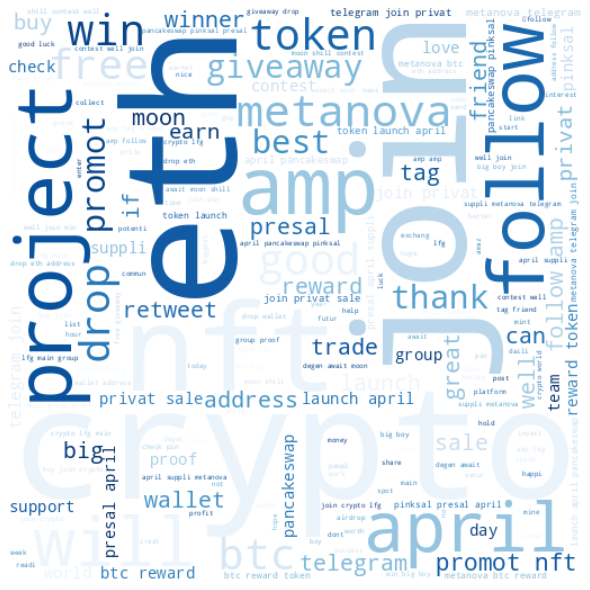

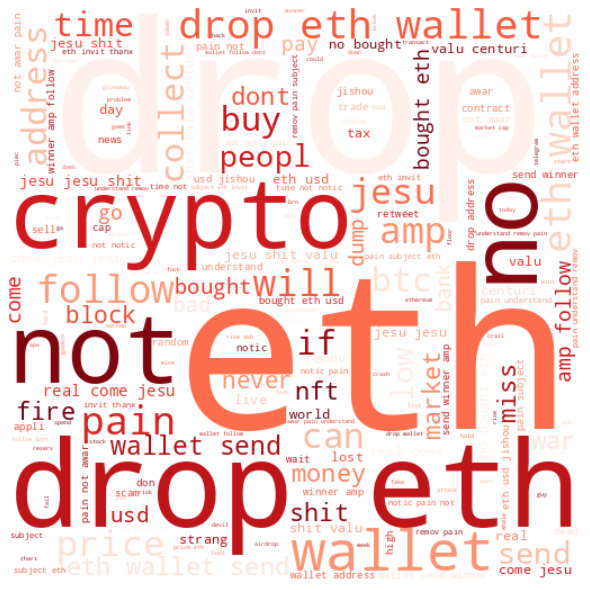

In [81]:
from PIL import Image
from wordcloud import WordCloud

allwords = df_tfidf.drop(['sentiment'], axis=1).sum(axis=0).sort_values(ascending=False)
pos_allwords = df_tfidf[(df_tfidf['sentiment']==1).values].drop(['sentiment'], axis=1).sum(axis=0).sort_values(ascending=False)
neg_allwords = df_tfidf[(df_tfidf['sentiment']==0).values].drop(['sentiment'], axis=1).sum(axis=0).sort_values(ascending=False)

def generate_wordcloud(filename, color, words_tem):
#     !cp /content/gdrive/My\ Drive/'Colab Notebooks'/'Sentiment Analysis'/mosque.png /content/
#     wine_mask = np.array(Image.open("mosque.png"))
#     def transform_format(val):
#         if val == 0:
#             return 255
#         else:
#             return val
#     transformed_wine_mask = np.ndarray((wine_mask.shape[0],wine_mask.shape[1]), np.int32)
#     for i in range(len(wine_mask)):
#         transformed_wine_mask[i] = list(map(transform_format, wine_mask[i]))

    word_cloud = WordCloud(colormap=color,
                           width = 512,
                           height = 512,
                           background_color='white',
                           mode="RGBA",
#                            mask=transformed_wine_mask
                          ).generate_from_frequencies(words_tem)
    plt.figure(figsize=(10,8),facecolor = 'white', edgecolor='blue')
    plt.imshow(word_cloud, interpolation='bilinear')
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.savefig(filename, format="png")
    #plt.show()
    

#generate_wordcloud('test.png','gist_rainbow',allwords)
generate_wordcloud('positive.png','Blues',pos_allwords)
generate_wordcloud('negative.png','Reds',neg_allwords)

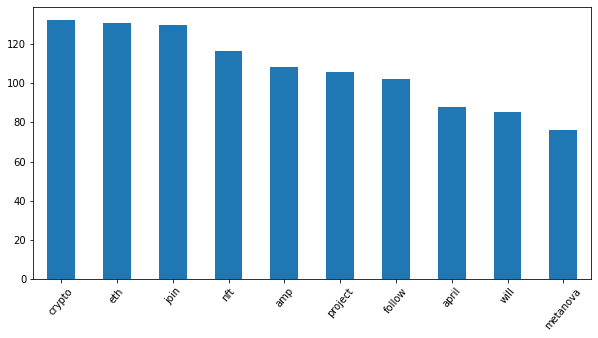

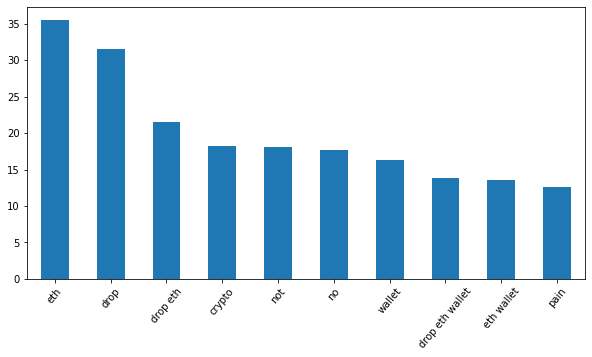

In [82]:
plt.figure(figsize=(10,5))
pos_allwords[:10].sort_values(ascending=False).plot.bar()
plt.xticks(rotation=50)
plt.show()

plt.figure(figsize=(10,5))
neg_allwords[:10].sort_values(ascending=False).plot.bar()
plt.xticks(rotation=50)
plt.show()